# Data Visualization

In [ ]:
!pip install ucsc_genomes_downloader
!pip install tqdm
!pip install keras_bed_sequence

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import pickle
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from cache_decorator import Cache
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.colors import LogNorm
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from keras_bed_sequence import BedSequence
from ucsc_genomes_downloader import Genome

In [ ]:
[cell_line, assembly, window_size] = ['HepG2', 'hg38', 256]

In [ ]:
genome = Genome(assembly)
genome

Loading chromosomes for genome hg38:   0%|          | 0/25 [00:00<?, ?it/s]

/home/emir/.local/lib/python3.10/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


Human, Homo sapiens, hg38, 2013-12-29, 25 chromosomes

In [ ]:
def to_bed(data:pd.DataFrame)->pd.DataFrame:
    """Return bed coordinates from given dataset."""
    return data.reset_index()[data.index.names]

In [ ]:
epigenomes = {
        "promoters": {},
        "enhancers": {}
    }

labels = {
        "promoters": {},
        "enhancers": {}
    }

binarized_labels = {
    "promoters": {},
    "enhancers": {}
}

with open('./epigenomes/epigenomes_enhancers.pkl', 'rb') as f:
    epigenomes["enhancers"] = pickle.load(file=f)
with open('./epigenomes/epigenomes_promoters.pkl', 'rb') as f:
    epigenomes["promoters"] = pickle.load(file=f)
with open('./epigenomes/labels_enhancers.pkl', 'rb') as f:
    labels["enhancers"] = pickle.load(file=f)
with open('./epigenomes/labels_promoters.pkl', 'rb') as f:
    labels["promoters"] = pickle.load(file=f)

In [ ]:
@Cache(
    cache_path="decompositions/tsne/{data_type}_{region}_{cell_line}_{metric}.pkl.gz",
    # We do not want to include the X variable into the hash
    args_to_ignore=["X"],
)
def get_tsne_decomposition(
    X: pd.DataFrame,
    data_type: str,
    region: str,
    cell_line: str,
    metric: str,
    perplexity:int
)->pd.DataFrame:

    TSNE()
    return pd.DataFrame(
        TSNE(
            metric=metric,
            perplexity=perplexity,
            verbose=0
        ).fit_transform(X.values),
        index=X.index
    )

@Cache(
    cache_path="decompositions/pca/{data_type}_{region}_{cell_line}_{metric}.pkl.gz",
    # We do not want to include the X variable into the hash
    args_to_ignore=["X"],
)
def get_pca_decomposition(
    X: pd.DataFrame,
    data_type: str,
    region: str,
    cell_line: str,
    metric: str,
    **kwargs
) -> pd.DataFrame:
    return pd.DataFrame(
        PCA(n_components=2).fit_transform(X.values),
        index=X.index
    )


def scatter_with_heatmap(
    decomposition: pd.DataFrame,
    scores: np.ndarray,
    figure: Figure,
    ax: Axes
):
    scatter = ax.scatter(
        *decomposition.values.T,
        c=scores,
        cmap=plt.cm.get_cmap('RdYlBu'),
        norm=LogNorm(),
        s=3,
    )
    color_bar = figure.colorbar(scatter, ax=ax)

Decomposition method:   0%|          | 0/2 [00:00<?, ?it/s]

Task:   0%|          | 0/2 [00:00<?, ?it/s]

/home/emir/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/emir/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/emir/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/emir/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/emir/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/emir/.local/lib/python3.10/site-packages/sklearn/manifo

Task:   0%|          | 0/2 [00:00<?, ?it/s]

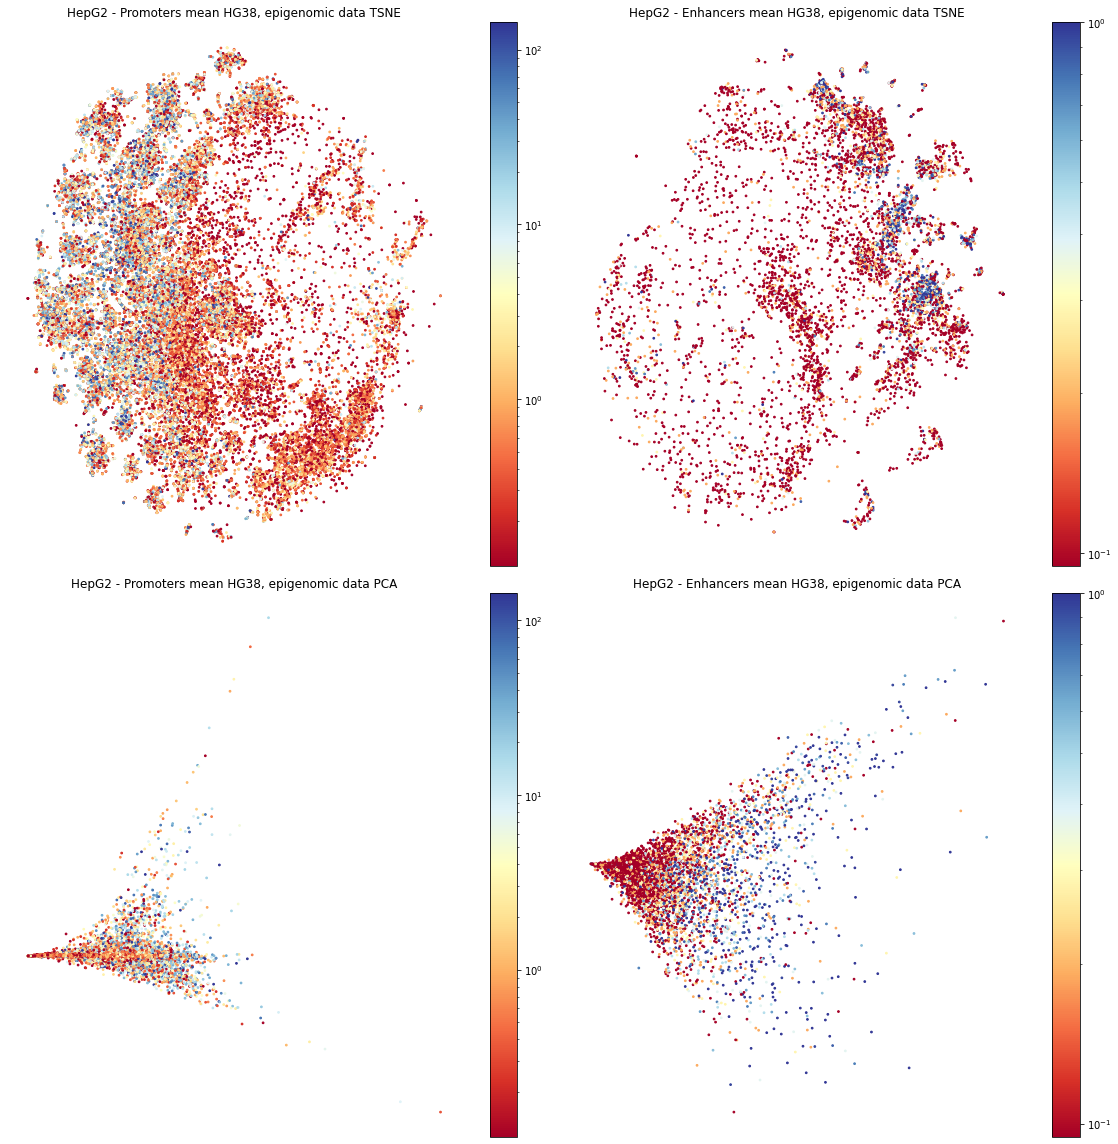

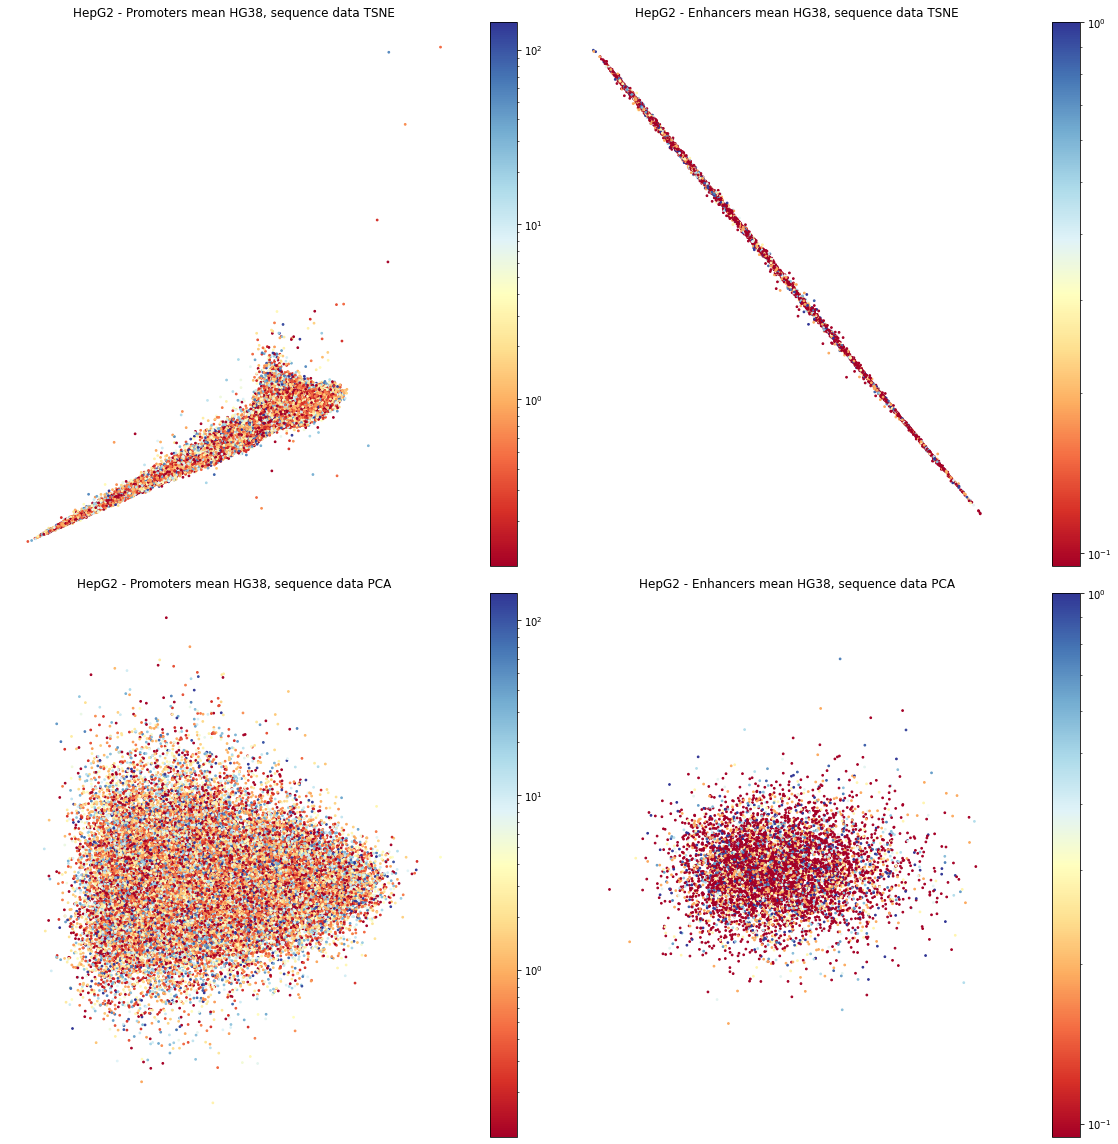

In [ ]:
epigenomic_fig, epigenomic_axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(16, 16),
    squeeze=False
)

sequence_fig, sequence_axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(16, 16),
    squeeze=False
)


for l, decomposition_method in enumerate(tqdm((get_tsne_decomposition, get_pca_decomposition), desc="Decomposition method", leave=False)):
    for j, ((epigenomic, scores), region) in enumerate(tqdm((
        ((epigenomes['promoters'], labels['promoters']), "Promoters"),
        ((epigenomes['enhancers'], labels['enhancers']), "Enhancers")
    ), desc="Task", leave=False)):
        
        decomposed_epigenomic = decomposition_method(
            epigenomic,
            "epigenomic",
            region,
            cell_line='HepG2',
            metric='cosine',
            perplexity=30
        )
        
        scatter_with_heatmap(
            decomposition=decomposed_epigenomic,
            scores=scores.values,
            figure=epigenomic_fig,
            ax=epigenomic_axes[l][j]
        )

        sequence = pd.DataFrame(
            np.array(BedSequence(
                genome,
                bed=to_bed(scores),
                batch_size=1
            )).reshape(-1, 4*256),
            index=scores.index
        )
        
        method = 'TSNE' if l == 0 else 'PCA'
        epigenomic_axes[l][j].set_title(f"{cell_line} - {region} mean HG38, epigenomic data {method}")
        epigenomic_axes[l][j].set_axis_off()

        decomposed_sequence = decomposition_method(
            sequence,
            "sequence",
            region,
            cell_line='HepG2',
            metric="cosine",
            perplexity=30
        )
        scatter_with_heatmap(
            decomposition=decomposed_sequence,
            scores=scores.values,
            figure=sequence_fig,
            ax=sequence_axes[l][j]
        )
        sequence_axes[l][j].set_title(f"{cell_line} - {region} mean HG38, sequence data {method}")
        sequence_axes[l][j].set_axis_off()

epigenomic_fig.tight_layout()
sequence_fig.tight_layout()
plt.show()

In [ ]:
import unittest

class Test(unittest.TestCase):
    def test_get_pca_decomposition(self):
        t = pd.DataFrame(np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]]))
        self.assertEqual(len(get_pca_decomposition( t, 'test','test','test','test').columns), 2)
        
    def test_get_tsne_decomposition(self):
        t = pd.DataFrame(np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]]))
        self.assertEqual(len(get_tsne_decomposition( t, 'test','test','test','cosine', 30).columns), 2)
    


In [ ]:
unittest.main(argv=[''], verbosity=2, exit=False)

test_get_pca_decomposition (__main__.Test) ... ok
test_get_tsne_decomposition (__main__.Test) ... /home/emir/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/emir/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
ok

----------------------------------------------------------------------
Ran 2 tests in 10.875s

OK
